In [1]:
#IMPPORT 
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib import animation
import warnings
warnings.filterwarnings('ignore')
import math 
import numpy as np
import matplotlib.cm as cm
from collections import deque
%matplotlib inline
from scipy import stats
from decimal import *
import random 
import scipy as sp
import collections
import heapq 
import seaborn as sns
sns.set()
sns.set(style = "ticks",palette = "pastel")
from copy import deepcopy
import matplotlib.patches as mpatches

In [19]:


def rij(i,j):
    r = (i.x[0] -j.x[0])**2 + (i.x[1] - j.x[1])**2
    return r

# veloctiy diff
def vij(i,j):
    v = (i.v[0] -j.v[0])**2 + (i.v[1] - j.v[1])**2
    return v

# inner product of r and v
def rv_ip(i,j):
    ip = np.dot(i.x-j.x, i.v-j.v)
    
    return ip

# expected time of collision of particle i and j 
def collision_particle(i,j):
    rv = rv_ip(i,j)
    r2 = rij(i,j)
    v2 = vij(i,j)
    dt = (r2 - (i.radius + j.radius)**2)/(-rv + np.sqrt(rv**2- v2*(r2 - (i.radius + j.radius)**2)))
    if np.isnan(dt): 
        return 10000
    return dt


# expected time of collision between particle and wall 
def collision_wall(i, R): 
    xv = np.dot(i.x, i.v)
    x2 = i.x[0]**2 + i.x[1]**2
    v2 = i.v[0]**2 + i.v[1]**2
    dt = (-xv + np.sqrt(xv**2 + v2*((R-i.radius)**2 - x2)))/v2
    if np.isnan(dt): 
        return 10000
    return dt

def update_pos(i, dti, index):
    
    global xs
    current_x = i.x
    #storage
    ts = np.arange(0, dti, 0.1)
    for t in ts:
        xs[index].append(current_x + t*i.v)
        
    i.x = i.x + dti*i.v   
    return 

# update position of i and j after collision
def update_velocity(i,j):
    
    if j is None: # collision with wall
        i.v = i.v - (2/(R-i.radius)**2) * np.dot(i.x,i.v)*i.x
        
    else: # collision with each other
        rhat = (i.x - j.x)/(i.radius + j.radius)
        vhat = i.v-j.v
        Mij = 2/(1/i.mass + 1/j.mass)
        Pij = Mij*np.dot(rhat, vhat)*rhat
        i.v= i.v - Pij/i.mass
        j.v = j.v + Pij/j.mass

    return 

In [39]:
# initial setups 
# initial setups 
def init_disk_square_2(R,N):
    atoms = []
    per_side = int(np.ceil(np.sqrt(N-1)))
    len_square = int(np.sqrt(2)*R)
    r = 2
    gridx = np.linspace(-len_square/2+10, len_square/2-5, per_side)
    gridy = np.linspace(-len_square/2+5, len_square/2-5, per_side)
    i=0
    j=0
    k =0 
    
    while i < N-1:
        
        if k == per_side:
            k =0 
            j = j+ 1
        x = gridx[j]
        y = gridy[k]
        vx = float(random.randrange(-30,30)) # random initial v
        vy = float(random.randrange(-30,30)) 
        m=1
        r = 2
        atom_i = Atom(x,y,vx,vy,r,m)
        atoms.append(atom_i)
        i = i+ 1   
        k = k+1 
        
    atom_i = Atom(-R+6,0,vx,vy,5,10)
    atoms.append(atom_i)
    return atoms

# puts atoms in a circle spaced like a square
def init_disk_square(R,N):
    atoms = []
    per_side = int(np.ceil(np.sqrt(N)))
    len_square = int(np.sqrt(2)*R)
    r = 2
    grid = np.linspace(-len_square/2+5, len_square/2-5, per_side)
    i=0
    j=0
    k =0 
    
    while i < N:
        
        if k == per_side:
            k =0 
            j = j+ 1
        x = grid[j]
        y = grid[k]
        if k!=0:
            vx = float(random.randrange(-20,20)) # random initial v
            vy = float(random.randrange(-20,20)) 
            m=1
            r = 2
        else:
            vx = 0 # random initial v
            vy = 0
            m=10
            r = 5
        atom_i = Atom(x,y,vx,vy,r,m)
        atoms.append(atom_i)
        i = i+ 1   
        k = k+1 
    return atoms

def init_RW(R,N):
    
    atoms = []
    r = 2
    grid = np.linspace(0, 2*np.pi - 0.2, N-1)
    i=0
    
    while i < N-1:
        x = (R-r-2)*np.cos(grid[i])
        y = (R-r-2)*np.sin(grid[i])
        if grid[i] <=np.pi/2:
            signx = -1
            signy = -1
        if grid[i] > np.pi/2 and grid[i]<= np.pi:
            signx = 1
            signy = -1
        if grid[i] > np.pi and grid[i]<= 3*np.pi/2:
            signx = 1
            signy =1
        if grid[i] > 3*np.pi/2 and grid[i]<= 2*np.pi:
            signx = -1
            signy = 1
        vx = signx*float(random.randrange(-100,100)) 
        vy = signy*float(random.randrange(-100,100)) 
        m=1
        atom_i = Atom(x,y,vx,vy,r,m)
        atoms.append(atom_i)
        i = i+1
    
    atom_i = Atom(0,0,0,0,70,100)
    atoms.append(atom_i)
    
    return atoms


In [4]:
class Atom:

    def __init__(atom, x, y, vx, vy, radius, mass):
        
        atom.x = np.array((x, y))
        atom.v = np.array((vx, vy))
        atom.radius = radius
        atom.mass = mass

In [5]:
def simulate_collision(R,N,C,atoms):
    global xs
    tracking = []
    xs = [[atoms[i].x] for i in range(N)]

    heap_list = []
    L = [-1 for i in range(N)]# storage of collision times per particle
    tau = 0 #time of last collision
    for i in range(N):
        for j in range(i+1, N):
            # estimate collision time 
            t_star = collision_particle(atoms[i], atoms[j]) + tau
            heap_list.append((t_star, tau, i, j))
        # estimate wall collision time 
        t_star = collision_wall(atoms[i],R) + tau
        heap_list.append((t_star, tau, i, -1))
    heapq.heapify(heap_list) 

    for c in range(C):
        invalid = 1
        while invalid:

            col = heapq.heappop(heap_list)

            if col[0] < col[1] or col[1] < (L[col[2]]- 1e-12) or (col[1] < (L[col[3]]- 1e-12) and col[3]!= -1):
                invalid = 1 
            else:
                invalid = 0

        for i in range(N):
            update_pos(atoms[i], col[0] - tau, i)  

        tau = col[0] # update time to current collision time
        tracking.append(col)
        if col[3] == -1: # collision with wall
            i = col[2]
            L[i] = tau
            update_velocity(atoms[i], None)
            for j in range(N):
                if j!= i:
                    t_star = collision_particle(atoms[i], atoms[j]) + tau
                    heapq.heappush(heap_list,(t_star, tau, i, j))
            t_star = collision_wall(atoms[i],R) + tau
            heapq.heappush(heap_list, (t_star, tau, col[2], -1))

        else: #collision with other particle
            i = col[2]
            j = col[3]
            L[i] = tau
            L[j] = tau
            update_velocity(atoms[i],atoms[j])
            for a in range(N):
                if a!= i and a!= j:
                    t_star = collision_particle(atoms[i], atoms[a]) + tau
                    heapq.heappush(heap_list, (t_star, tau, col[2], a))
            t_star = collision_wall(atoms[i],R) + tau
            heapq.heappush(heap_list, (t_star, tau, i, -1))

            for a in range(N): 
                if a!= i and a!= j:
                    t_star = collision_particle(atoms[j], atoms[a]) + tau
                    heapq.heappush(heap_list, (t_star, tau, col[3], a))
            t_star = collision_wall(atoms[j],R) + tau
            heapq.heappush(heap_list, (t_star, tau, j, -1))      
    return tau

In [49]:
R = 50
N= 170
C = 20000
atoms = []
atoms = init_disk_square_2(R,N)
v_init = [atoms[i].v for i in range(N)]
x_start =  [atoms[i].x for i in range(N)]

energy_init = 0
for i in range(N):
    energy_init = energy_init + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 
print(energy_init)   
simulate_collision(R,N,C,atoms)

energy_final = 0
for i in range(N):
    energy_final = energy_final + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 
    
print('Energy lost: %.10f' %(energy_init-energy_final))     



50570.5
Energy lost: 0.0000000052


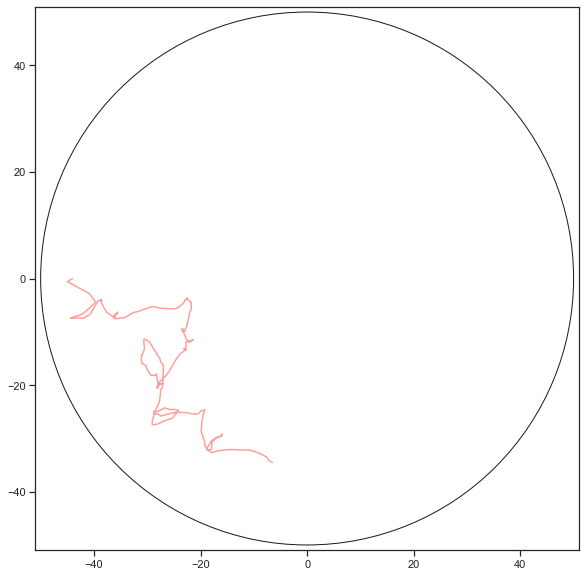

In [55]:
%matplotlib inline
xsx = np.array(xs)
circle1 = plt.Circle((0, 0), R, color='k', fill = False)
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.set_ylim(-(R+1),(R+1))
ax.set_xlim(-(R+1),(R+1))
ax.add_artist(circle1)
rads = [atoms[i].radius for i in range(N)]
#for i in range(N):
#    ax.plot(xsx[i,:][:,0],xsx[i,:][:,1])    
#    circle2 = plt.Circle((xsx[i][0][0], xsx[i][0][1]), rads[i], color='m', linewidth=0,fill = True)
#    ax.add_artist(circle2)
#    circle3= plt.Circle((xsx[i][-1][0], xsx[i][-1][1]), rads[i], color='r', linewidth=0, fill = True)
#    ax.add_artist(circle3)

ax.plot(xsx[N-1,:][:,0],xsx[N-1,:][:,1], 'r')

ax.set_aspect(1)
plt.savefig('RW.png', bbox_inches='tight', dpi = 800 )

170


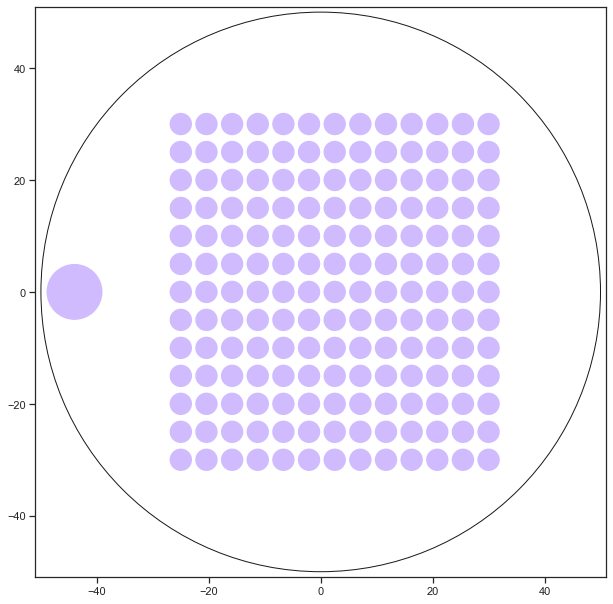

In [42]:
R = 50
N= 170
circle1 = plt.Circle((0, 0), R, color='k', fill = False)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_ylim(-(R+1),(R+1))
ax.set_xlim(-(R+1),(R+1))
ax.add_patch(circle1)
ax.set_aspect(1)

atoms = init_disk_square_2(R,N)
print(len(atoms))

circles = [plt.Circle((a.x[0],a.x[1]), radius=a.radius, linewidth=0, color = 'm') for a in atoms ]
c = matplotlib.collections.PatchCollection(circles,match_original=True)
ax.add_collection(c)
#plt.colorbar(c)

<IPython.core.display.Javascript object>


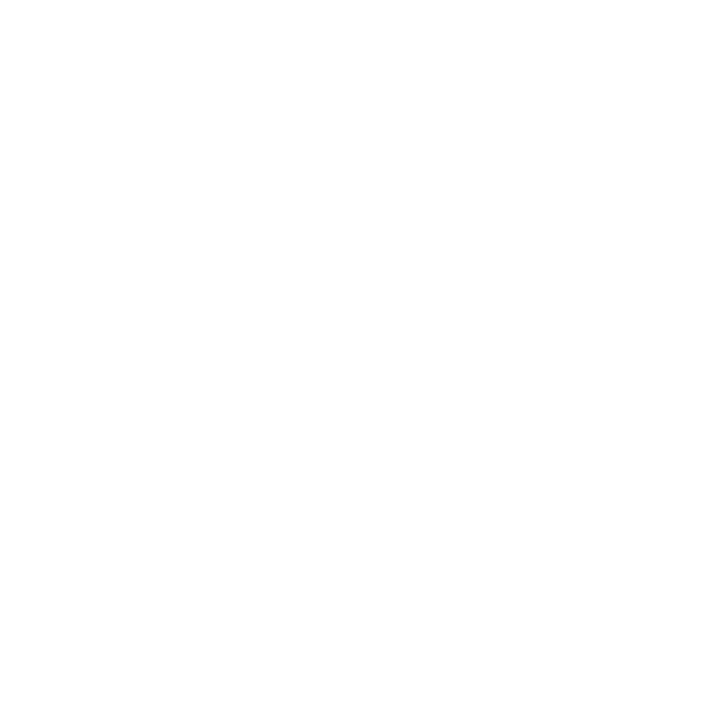

<IPython.core.display.Javascript object>


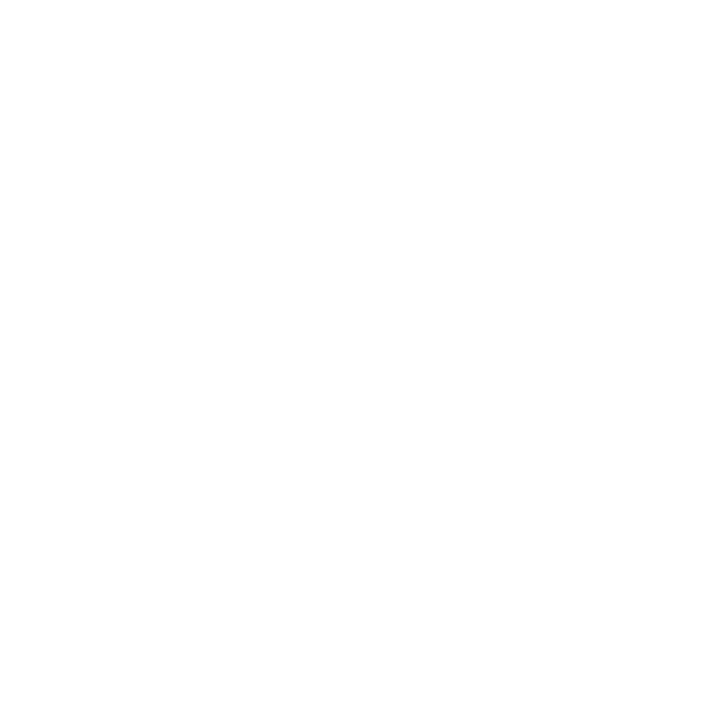

Traceback (most recent call last):
  File "C:\Users\janic\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\janic\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [52]:

%matplotlib notebook

xsx = np.array(xs)
R=50
N = 170

fig=plt.figure()
ax = plt.axes(xlim=(-(R+1),(R+1)), ylim=(-(R+1),(R+1)))
fig.set_size_inches(10, 10)
circle1 = plt.Circle((0, 0), R, color='k', fill = False)
ax.add_patch(circle1)
ax.set_aspect(1)


#ax = plt.axes(xlim=(0, 40), ylim=(0, 40))
rads = [atoms[i].radius for i in range(N)]
dict_of_circles = {}
for i in range(N):
    dict_of_circles["circle"+str(i+1)] = plt.Circle((xsx[i][0][0], xsx[i][0][1]),atoms[i].radius,fc='b')

def init():
    for i in range(N):
        dict_of_circles["circle"+str(i+1)].center = (xsx[i][0][0], xsx[i][0][1])
        ax.add_patch(dict_of_circles["circle"+str(i+1)])
    return dict_of_circles.values()

def animate(i):
    for n in range(N):
        dict_of_circles["circle"+str(n+1)].center = (xsx[n][i][0], xsx[n][i][1])
    return dict_of_circles.values()

anim=animation.FuncAnimation(fig,animate,init_func=init,frames=len(xsx[0]),blit=True)
anim.save(
  filename='test.mp4',
  fps=60,
  dpi=200,
)